# Setting

Given a diverse set of development indicators, the models below aim to forecast mixed-migration flows between selected country pairs. "Mixed-migration" refers to movement of populations in aggregate (includes vulnerable populations such as refugees fleeing violence, those seeking asylum, and migration due to economic and environmental reasons).

Development indicators have been gathered from a variety of institutional provides (e.g. Worldbank, UNDESA, UNHCR) and these have been linked to specific migration drivers identified by the Danish Refugee Council interviews under the [4MI project](http://www.mixedmigration.org/4mi/). 


This notebook demonstrates the use of machine learning pipelines to determine mixed-migration forecasts. A forecast in this context consists of three outputs: 

- a point forecast on bilateral country-level flows (number of persons), 
- a 95% confidence interval to capture the uncertainty around the point forecasting, and
- an explanation of how the forecasts were influenced by various indicator variable.


## Models

TBC


In [ ]:
import pandas as pd
from time import time
import os
import json
import pickle
import numpy as np 
from time import time

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 
sns.set(style="white")


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn import metrics

# load JS visualization code to notebook (for SHAP)
import shap
shap.initjs()

# Data transformations

Review the [README.md](README.md) file on how to download and set up a copy of the pre-processed data. We'll use the [configuration.json](configuration.json) file to gather all the sources.

We focus on 6 bilateral flows for this phase all originating in Ethiopia. The destination countries are: Saudi Arabia, Italy, Great Britain, Denmark, Sweden, and South Africa. These variables are included in the pre-processed dataset and are encoded as `ETH.TO.xxx` (where `xxx` refers to the ISO-3 code of the destination country). 


In [ ]:
start_time = time()
with open("configuration.json", 'rt') as infile:
    config = json.load(infile)


sources = [os.path.join(config['paths']['output'], 
                        d['name'], 
                        'data.csv') for d in config['sources']]


# Generate a data frame with all indicators
df = pd.concat((pd.read_csv(f) for f in sources), sort=False, ignore_index=True)

# Summary stats
print("Sources            : {}".format(len(sources)))
print("Shape              : {} (rows) {} (columns)".format(*df.shape))
print("Geographies        : {}".format(len(df['Country Name'].unique())))
print("Indicators         : {}".format(len(df['Indicator Code'].unique())))
print("Temporal coverage  : {} -> {}".format(df.year.min(), df.year.max()))
print("Null values        : {}".format(sum(df['value'].isnull())))

print("\nLoaded data in {:3.2f} sec.".format(time() - start_time))


# Now arrange data in long form
data = pd.pivot_table(df, index=['Country Code', 'year'],
                      columns='Indicator Code', values='value')

# Consider country/year as features (and not an index)
data.reset_index(inplace=True)

print("Long form of size  : {} (rows) {} (columns)".format(*data.shape))

## Data plots

### Correlations 
We look at pairwise correlation between the indicators and target forecast variables. This plot ignores temporal lag effects! 

In [ ]:
cols = list(set(data.columns) - set(['year']))
cols.sort()

# Compute the correlation matrix
corr = data[cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(font_scale=0.5)
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

target_vars = [i - 1 for i, k in enumerate(cols) if k.startswith("ETH.TO.")]
xticks = ax.get_xticklabels()
yticks = ax.get_yticklabels()
[xticks[t].set_color("red") for t in target_vars]
[xticks[t].set_fontweight("bold") for t in target_vars]
[yticks[t].set_color("red") for t in target_vars]
[yticks[t].set_fontweight("bold") for t in target_vars]

plt.savefig("img/correlation.png", dpi=200, bbox_inches='tight')

### Auto-correlation

How stable are mixed-migration flows over time? We look at correlation from one year to the next. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.

The plots show high auto-correlation. 

In [ ]:
from pandas.plotting import autocorrelation_plot
sns.set(font_scale=1.0)

TARGETS = ['ETH.TO.SAU', 'ETH.TO.ITA', 
           'ETH.TO.GBR', 'ETH.TO.DNK',
           'ETH.TO.SWE', 'ETH.TO.ZAF']

fig, ax = plt.subplots(1, len(TARGETS), 
                       figsize=(20, 4), 
                       sharex='col', sharey='row')

for i, t in enumerate(TARGETS):
    
    idx = data['Country Code'] == 'ETH'
    tmp = data.loc[idx, ['year', t]]
    tmp = tmp[~tmp[t].isnull()]
    
    autocorrelation_plot(tmp, ax=ax[i])
    ax[i].set_title("{} (n={})".format(t, len(tmp)))
    ax[i].set_xlim([0, 20])
    ax[i].set_xlabel('Lag (years)');

plt.savefig("img/autocorrelation.png", dpi=200, bbox_inches='tight')

In [ ]:
# Scatter plots (per DRC request)

sns.set(style="white")
fig, ax = plt.subplots(1, len(TARGETS), 
                       figsize=(20, 4))

for i, t in enumerate(TARGETS):
    
    idx = data['Country Code'] == 'ETH'
    tmp = data.loc[idx, ['year', t]]
    tmp = tmp[~tmp[t].isnull()]
    
    tmp.sort_values(by='year', inplace=True)
    tmp['T-1'] = tmp[t].shift(1)
    
    ax[i].scatter(tmp[t], tmp['T-1'])
    ax[i].plot(tmp[t], tmp[t], '-r')
    ax[i].set_aspect('equal', adjustable='box')
    ax[i].set_title("{} (n={})".format(t, len(tmp)))
    ax[i].set_yticks([], [])
    ax[i].set_ylabel('time $t-1$')
    ax[i].set_xlabel('time $t$');

plt.savefig("img/autocorrelation-scatter.png", dpi=200, bbox_inches='tight')

# Features

What aspects of the data are useful to a forecasting model of mixed-migration? A feature is an attribute in the data that is useful in make a prediction. It is an information signal that can help determine if migration will be high versus low. We generate a variety of feature sets based on the raw indicators aggregated above.

The following feature sets are considered:
#### Geography
- **ETH** : Use indicators for Ethiopia as a source country. 
- **SSA** : Use all indicators for Sub-Saharan African (SSA) countries to make up for the sparsity of data for Ethiopia. The intent being that the relationships between mixed-migration and indicators are more general. 
- **DUMMY** : Same as above but include dummy variables for each country. This has the impact that country specific relationships are learnt. 
- **DEST**: include destinations-specific feature sets.

#### Temporal
- **AR($n$)** : Autocorrelation features. Include previous $n$ year's migration numbers as a feature.
- **TLAG$n$** : Temporal lag features of $n$ years.


The model is of the form
$y_{ij} (t+1) = f\left( y_{ij}(t), X_i(t), X_j(t)\right)$, where

migration flows ($y$) from $i$ to $j$ for a future time period, are related to current migration flows, and macro indicators for source country $X_i(t)$ and for the destination country $X_j(t)$.  

In [ ]:
# Sub-Saharan countries codes
SSA = ['BDI', 'COM', 'DJI', 'ERI', 'ETH', 'ATF', 'KEN', 'MDG', 'MWI', 
       'MUS', 'MYT', 'MOZ', 'REU', 'RWA', 'SYC', 'SOM', 'SSD', 'TZA', 
       'UGA', 'ZMB', 'ZWE']

def lag_variables(data, var, lag):
    """
    Append lagged variables to frame.
    
    data - pandas data frame
    var - list of variable names to lag
    lag - integer
    
    """
    idx_cols = ['year', 'Country Code']
    fv = var + idx_cols
    
    tmp = data[fv].copy(deep=True)
    
    col_name = [v + ".T" + "{0:+}".format(lag) for v in var]
    
    tmp.rename(columns={k: v for (k, v) in zip(var, col_name)},
               inplace=True)
    tmp.year -= lag
    data = pd.merge(data, tmp, on=idx_cols, how='left')
    
    return data, col_name


def generate_features(data, 
                      training_years,
                      forecast_year,
                      target_var,
                      feature_var,
                      feature_sets=None):
    """ 
    #TODO: Grew out over time and needs a refactor.
    
    Generate a feature set for training/test
    
    data: pandas Dataframe in long form with all indicator variables
    training_years: Tuple showing min-max years to train on, e.g. (1995, 2010)
    forecast_year: test year, (2011)
    target_var: variable name to forecast e.g. 'ETH.TO.GBR'
    feature_var: list of variables to include
    feature_sets: (optional) string with feature sets to consider, e.g. 'ETH+TLAG+DEST'
    
    returns: 
        Dictionary with training, test data, along with the baseline
        Baseline is the latest flow in the training data.
    """
    
    source, _, destination = target_var.split(".")
    
    true_feature_var = [f for f in feature_var]
    # print("Total # Features: {}".format(len(true_feature_var)))
    
    if feature_sets is None:
        feature_sets = 'SSA+DUMMY+AR'
    
    dcols = data.columns
    assert target_var in dcols,\
        "Target variable '{}' must be in data frame.".format(target_var)
    for fv in feature_var:
        assert fv in dcols,\
            "Feature variable '{}' does not exist.".format(fv)
        
    # Get the poor man's forecast as baseline
    bv = data.loc[(data.year == forecast_year - 1) & 
                  (data['Country Code'] == source), target_var].values[0]
    # print("Baseline value: {} (year {})".format(bv, forecast_year - 1))
    
    # Get the true value
    tr = data.loc[(data.year == forecast_year) & 
                  (data['Country Code'] == source), target_var].values[0]
    # print("True value: {} (year {})".format(tr, forecast_year))
    
    # Target variable offset by a year (y_(t+1))
    data, varname = lag_variables(data, [target_var], 1)
    true_target_var = varname[0]
    
    # Temporal filter: since the target variable is lagged, the training
    # year is one year prior.
    yl, yu = training_years
    t1 = data.year.between(*(yl, yu - 1))
    v1 = data.year == forecast_year - 1 
    
    # Spatial filter
    if "SSA" in feature_sets:
        t2 = data['Country Code'].isin(SSA)
        
    elif "ETH" in feature_sets:
        t2 = data['Country Code'] == "ETH"
        
    else:
        ValueError("Spatial criteria not set (select either SSA/ETH).")
    
    v2 = data['Country Code'] == source
    
    # Variable additions 
    if "DUMMY" in feature_sets:
        
        # Generate one hot encodings of the country labels
        tmp = pd.get_dummies(data['Country Code'])
        
        data = pd.concat([data, tmp], axis=1)
        
        # Include dummy variables in the feature_set
        # if we have data for them and they are for Sub-Saharan Africa
        true_feature_var += [s for s in SSA if s in tmp.columns]
        # print("Country-specific dummy variables")
        # print("Total # Features: {}".format(len(true_feature_var)))
        
    if "AR" in feature_sets:
        
        # For an AR(1) we just include current year value
        true_feature_var += [target_var]
        
        """
        # For AR(2) and above - need to generate features 
        data, varname = lag_variables(data, [target_var], -1)
        
        # Add to the feature set to extract
        true_feature_var += varname
        """
        
        # print("Autoregressive features.")
        # print("Total # Features: {}".format(len(true_feature_var)))
        
    if "DEST" in feature_sets:
        # Include feature set from destination country
        idx = data['Country Code'] == destination
        d_df = data.loc[idx, ['year'] + feature_var].copy(deep=True)
        data = pd.merge(data, d_df, on='year', suffixes=('', '.DEST'), how='left')
        true_feature_var += [v + ".DEST" for v in feature_var]
        # print("Destination features")
        # print("Total # Features: {}".format(len(true_feature_var)))
    
    if "TLAG" in feature_sets:
        # Include temporal lag features
        data, varname = lag_variables(data, feature_var, -1)
        true_feature_var += varname
        # print("Temporal lag variables")
        # print("Total # Features: {}".format(len(true_feature_var)))
        
    # Pull it all together ->

    # Training data
    Xt = data.loc[t1 & t2, true_feature_var]
    yt = data.loc[t1 & t2, true_target_var]
    
    # Forecast/validation data
    Xv = data.loc[v1 & v2, true_feature_var]
    yv = data.loc[v1 & v2, true_target_var]
    
    # Drop missing training labels
    idx = ~pd.isnull(yt)
    yt = yt[idx]
    Xt = Xt[idx]
    
    """
    # Handle missing values
    for g in [Xt, yt, Xv, yv]:
        g.fillna(-100000.0, inplace=True)
    
    print("Feature set")
    print(Xt.columns.values)
    
    print("Test variable")
    print(yt.name)
    """
    
    return {'data': (Xt, yt, Xv, yv), 'baseline': bv, 'true': tr}

## Point forecasts with confidence intervals

A model is trained for each target variable, and a point forecast along with the confidence interval using a quantile regressor. 

In [ ]:
def missing_vals(x, v=-100000.0):
    idx = np.isnan(x)
    x[idx] = v
    return x
    
def intervals(Xt, yt, Xv, yv):
    """ Quantile regressor for confidence intervals """

    # Handle missing values - since scikit doesn't deal
    # with this.
    Xt = missing_vals(Xt)
    #yt = missing_vals(yt)
    Xv = missing_vals(Xv)
    
    alpha = 0.95
    clf = GradientBoostingRegressor(loss='quantile', 
                                    alpha=alpha,
                                    n_estimators=250, 
                                    max_depth=3,
                                    learning_rate=.1, 
                                    min_samples_split=9)

    clf.fit(Xt, yt)
    y_upper = clf.predict(Xv)

    clf.set_params(alpha = 1.0 - alpha)
    clf.fit(Xt, yt)

    y_lower = clf.predict(Xv)
    
    return y_lower, y_upper

def improvements(y, b, f):
    """ Percentage improvement in error over base line """
    
    db = max(np.abs(y - b), 0.0001)
    df = np.abs(y - f)
    
    return ((db - df)/db)
    

# Feature-Model selection

What combination of features and model forms perform the best on the validation set? We evaluate a battery of feature combinations and models here.

In [ ]:
# Variables to predict
TARGETS = ['ETH.TO.SAU', 'ETH.TO.ITA', 'ETH.TO.GBR',
           'ETH.TO.DNK', 'ETH.TO.SWE', 'ETH.TO.ZAF']

# Years to predict the variables for (all one-year ahead)
PERIODS = [{'train_years': (1995, Y-1), 
            'predict_year': Y } for Y in np.arange(2011, 2016, 1)]

# Feature combinations to evaluate
FSETS = ['ETH', 'SSA', 'SSA+DUMMY',
         'ETH+AR', 'SSA+AR', 'SSA+DUMMY+AR',
         'ETH+AR+DEST', 'SSA+AR+DEST', 'SSA+DUMMY+AR+DEST',
         'ETH+AR+DEST+TLAG', 'SSA+AR+DEST+TLAG', 'SSA+DUMMY+AR+DEST+TLAG']


"""# Debug config
FSETS = ['ETH']
PERIODS = [{'train_years': (1995, Y-1), 
            'predict_year': Y } for Y in np.arange(2011, 2012, 1)]
TARGETS = ['ETH.TO.SAU']"""

# Models to evaluate
MODELS = [('XGBoost', Pipeline([("Preprocessor", SimpleImputer(strategy='mean')),
                                ("Estimator", GradientBoostingRegressor(n_estimators=500, 
                                                                 max_depth=4, 
                                                                 min_samples_split=2,
                                                                 learning_rate=0.01, 
                                                                 loss='ls'))])),
          ("Linear Regression", linear_model.LinearRegression()),
          ("Support Vector Regression", SVR(gamma='auto'))]


# Set of variables to consider as features
indicators = list(set(data.columns) 
                    - set(TARGETS + ['Country Code', 'year']))

NUM_MODELS = len(TARGETS) * len(PERIODS) * len(FSETS) * len(MODELS)
print("Testing {} combos.".format(NUM_MODELS))

results = []
batch = 0
start_time = time()

for target in TARGETS:
    
    for p in PERIODS:
        
        batch += 1

        for fs in FSETS:
            
            # Generate problem instance
            d = generate_features(data, 
                      p['train_years'],
                      p['predict_year'],
                      target,
                      indicators,
                      feature_sets=fs)
            
            Xt, yt, Xv, yv = d['data']
            
            for lbl, clf in MODELS:
                
                M = {}
                M['batch'] = batch
                M['period'] = p
                M['target'] = target 
                M['baseline'] = d['baseline']
                M['true'] = yv.values[0]
                M['features'] = fs
                
                # And finally run battery of models
                M['model'] = lbl
                
                clf.fit(Xt, yt)
                fc = clf.predict(Xv)
                M['forecast'] = fc[0]
                M['CI'] = intervals(Xt, yt, Xv, yv)

                # MAE
                M['mae'] = metrics.mean_absolute_error(yv, fc)

                # Compare to baseline
                M['IMP'] = improvements(yv.values[0], M['baseline'], M['forecast'])
                
                results.append(M)
    

with open("result.pkl", 'wb') as outfile:
    pickle.dump(results, outfile)
    
print("Done with {} runs in in {:3.2f} sec.".format(len(results), time() - start_time))

## Feature-model analysis

The various combinations are evaluated based on the point forecast alone. The two metrics used are the percentage improvement over the baseline (using the current year's data) and the mean absolute error. 

In [ ]:
with open("result.pkl", 'rb') as outfile:
    print("Using cached results.")
    results = pickle.load(outfile)
    
df_acc = pd.DataFrame(results)

df_acc.drop(columns=['CI', 'baseline', 'forecast', 'true', 'period', 'batch'], inplace=True)

# Top feature/model pairs
groups = df_acc.groupby(['target', 'features', 'model']).agg([np.median, np.mean, np.min, np.max])
        
groups.reset_index(inplace=True)

groups.sort_values(['target', ("mae", "median")], inplace=True)

groups.set_index("target", append=True, inplace=True)

groups.columns = ['-'.join(col) for col in groups.columns]
            
tmp = ['median', 'mean', 'amin', 'amax']

(groups
 .style
 .set_properties(**{'text-align': 'right'})
 .format({"IMP-{}".format(c): "{:.0%}" for c in tmp})
 .format({"mae-{}".format(c): "{:.0f}" for c in tmp}))


The results above suggest, based on the validation set, the `XGBoost` model performs the best from most of the targets, but a linear regression does well for two (`SAU` and `SWE`). The various feature sets offer some trade-offs between the various metrics. There is no single feature set that consistently does best for all movements.

# Validation

The chosen models are now evaluated more closely for (a) forecast explanations, and (b) any missed forecasts and reasons for the missed forecast.

## Point forecast


In [56]:
from sklearn.base import clone
MODELS = [('XGBoost', Pipeline([("Preprocessor", SimpleImputer(strategy='mean')),
                                ("Estimator", GradientBoostingRegressor(n_estimators=500, 
                                                                 max_depth=4, 
                                                                 min_samples_split=2,
                                                                 learning_rate=0.01, 
                                                                 loss='ls'))])),
          ("Linear Regression", Pipeline([("Preprocessor", SimpleImputer(strategy='mean')),
                                ("Estimator", linear_model.LinearRegression())]))]


# Models selected
TARGETS = [{'targets': 'ETH.TO.DNK',
            'features': 'ETH',
            'model': ("XGBoost", clone(MODELS[0][1]))},
           {'targets': 'ETH.TO.GBR',
            'features': 'SSA+DUMMY+AR+DEST',
            'model': ("XGBoost", clone(MODELS[0][1]))},
           {'targets': 'ETH.TO.ITA',
            'features': 'ETH+AR',
            'model': ("XGBoost", clone(MODELS[0][1]))},
           {'targets': 'ETH.TO.SAU',
            'features': 'ETH+AR+DEST+TLAG',
            'model': ("Linear Regression", clone(MODELS[1][1]))},
           {'targets': 'ETH.TO.SWE',
            'features': 'SSA+AR',
            'model': ("Linear Regression", clone(MODELS[1][1]))},
           {'targets': 'ETH.TO.ZAF',
            'features': 'SSA+DUMMY+AR+DEST',
            'model': ("XGBoost", clone(MODELS[0][1]))}
          ]

# Years to predict the variables for (all one-year ahead)
PERIODS = [{'train_years': (1995, Y-1), 
            'predict_year': Y } for Y in np.arange(2010, 2017, 1)]


# Set of variables to consider as features
indicators = list(set(data.columns) 
                    - set([t['targets'] for t in TARGETS]
                          + ['Country Code', 'year']))

results = []
start_time = time()

for target in TARGETS:
    
    for p in PERIODS:        
    
        # Generate problem instance
        d = generate_features(data, 
                  p['train_years'],
                  p['predict_year'],
                  target['targets'],
                  indicators,
                  feature_sets=target['features'])

        Xt, yt, Xv, yv = d['data']
        
        lbl, clf = target['model']

        M = {}
        M['period'] = p
        M['target'] = target['targets']
        M['baseline'] = d['baseline']
        M['true'] = yv.values[0]
        M['features'] = target['features']
        M['model'] = lbl

        clf.fit(Xt, yt)
        fc = clf.predict(Xv)
        M['clf'] = clf
        M['forecast'] = fc[0]
        M['CI'] = intervals(Xt, yt, Xv, yv)

        # MAE
        M['mae'] = metrics.mean_absolute_error(yv, fc)

        # Compare to baseline
        M['IMP'] = improvements(yv.values[0], M['baseline'], M['forecast'])

        results.append(M)

with open("models.pkl", 'wb') as outfile:
    pickle.dump(results, outfile)
    
print("Done with {} runs in in {:3.2f} sec.".format(len(results), time() - start_time))

Done with 42 runs in in 46.92 sec.


## Validation set plots

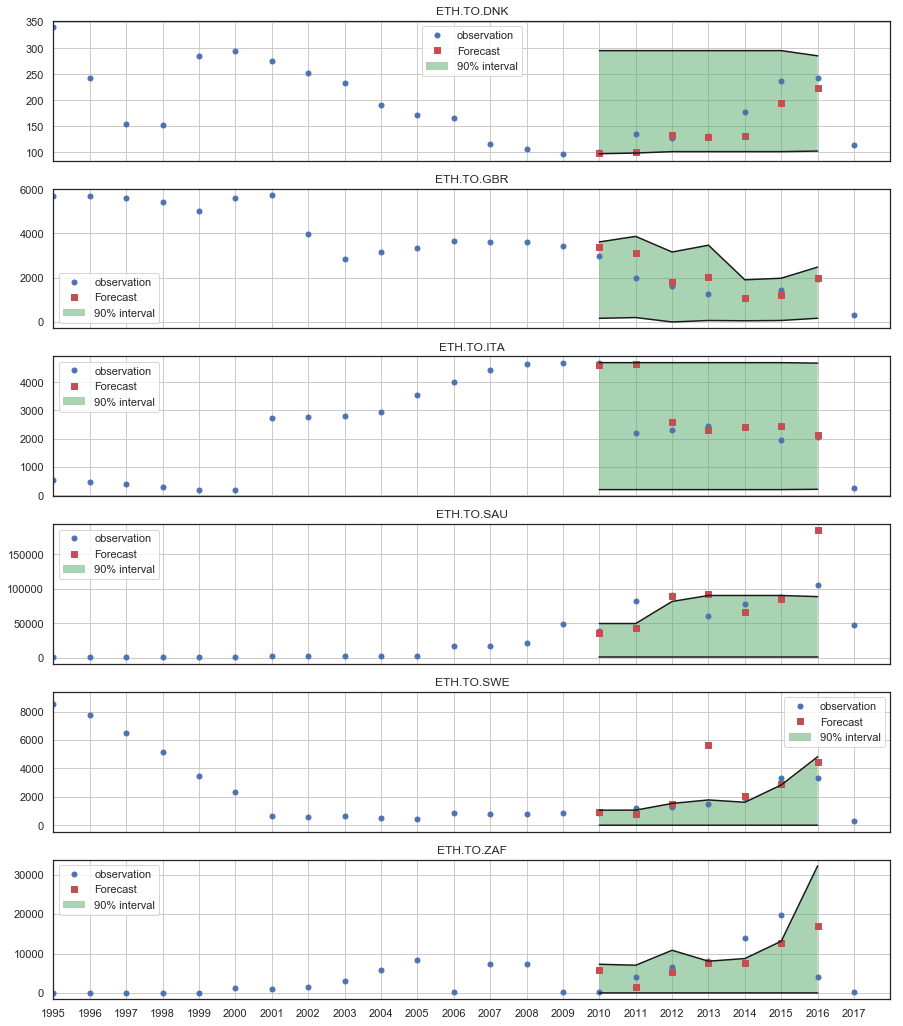

In [59]:
f, axarr = plt.subplots(len(TARGETS), figsize=(15, 18), sharex=True)

for i, t in enumerate(TARGETS):
    
    target = t['targets']
    
    # Get the observations (from raw data)
    idx = (df['Indicator Code'] == target) & (df['Country Code'] == 'ETH')
    obs_x = df.loc[idx, 'year']
    obs_y = df.loc[idx, 'value']
    axarr[i].plot(obs_x, obs_y, 'b.', markersize=10, label='observation')
    
    # Get the forecast
    for_x = [k['period']['predict_year'] for k in results if k['target'] == target]
    for_y = [k['forecast'] for k in results if k['target'] == target]
    ci_low_y = [k['CI'][0] for k in results if k['target'] == target]
    ci_hig_y = [k['CI'][1] for k in results if k['target'] == target]
    
    axarr[i].plot(for_x, for_y, 'rs', label=u'Forecast')
    axarr[i].plot(for_x, ci_hig_y, 'k-')
    axarr[i].plot(for_x, ci_low_y, 'k-')
    axarr[i].fill(np.concatenate([for_x, for_x[::-1]]),
         np.concatenate([ci_hig_y, ci_low_y[::-1]]),
         alpha=.5, fc='g', ec='None', label='90% interval')
    
    axarr[i].grid(True)
    axarr[i].legend(loc=0)
    plt.xlim([1995, 2018])
    plt.xticks(np.arange(1995, 2018, 1))
    axarr[i].set_title(target)
    #plt.suptitle("Year ahead forecasts 2011 - 2017")
        
    
plt.savefig("img/Forecast-XGB.png", dpi=200, bbox_inches='tight')

In [60]:

acc = pd.DataFrame(results)

acc['year'] = acc['period'].apply(lambda x: x['predict_year'])
acc['destination'] = acc['target'].apply(lambda x: x.split(".")[2])

acc.drop(columns=['CI', 'features', 'clf', 'model', 'period', 'target'], inplace=True)

summary = acc.pivot(index='destination', columns='year', values=['IMP', 'mae'])
(summary
 .style
 .set_properties(**{'text-align': 'right'})
 .format({("IMP", c): "{:.0%}" for c in acc['year'].unique()})
 .format({("mae", c): "{:.0f}" for c in acc['year'].unique()}))
          

In [61]:
# Per DRC request, what are the error rates per country
acc = pd.DataFrame(results)

acc['year'] = acc['period'].apply(lambda x: x['predict_year'])
acc['destination'] = acc['target'].apply(lambda x: x.split(".")[2])

acc.drop(columns=['CI', 'features', 'baseline', 'forecast', 'year', 'true', 'clf', 'model', 'period', 'target'], inplace=True)
grp = acc.groupby(['destination']).agg(np.median)

(grp
 .style
 .set_properties(**{'text-align': 'right'})
 .format({"IMP": "{:.0%}", "mae": "{:.0f}"}))

,IMP,mae
destination,,
DNK,20%,21
GBR,31%,247
ITA,1%,119
SAU,32%,11937
SWE,-105%,406
ZAF,17%,5629


# Feature importance

Besides autoregressive features, what factors influence migration? For a single year we look to rank features for forecasting.

In [70]:
from sklearn.base import clone

TARGETS = ['ETH.TO.SAU', 'ETH.TO.ITA', 'ETH.TO.GBR',
           'ETH.TO.DNK', 'ETH.TO.SWE', 'ETH.TO.ZAF']

# Just pick a single year for this experiment
P = {'train_years': (1995, 2013), 
     'predict_year': 2014}

# Chosen feature combination
FSET = 'SSA+AR+TLAG'

# Chosen pipeline
clf = Pipeline([("Preprocessor", SimpleImputer(strategy='mean')),
                ("Estimator", GradientBoostingRegressor(n_estimators=400, 
                                                 max_depth=3, 
                                                 min_samples_split=2,
                                                 learning_rate=0.01, 
                                                 loss='ls'))])
# Set of variables to consider as features
indicators = list(set(data.columns) 
                    - set(TARGETS
                    + ['Country Code', 'year']))

M = []
for t in TARGETS:
    # Generate problem instance
    d = generate_features(data, 
              P['train_years'],
              P['predict_year'],
              t,
              indicators,
              feature_sets=FSET)

    Xt, yt, Xv, yv = d['data']
    
    # Remove all null columns
    Xt.dropna(axis=1, how='all', inplace=True)
    
    tmp = clone(clf)
    tmp.fit(Xt, yt)
    # print("Feature size {}, {}".format(*Xt.shape))
    # print("Model feature length {}".format(len(tmp.steps[1][1].feature_importances_)))
    
    M.append({'target': t, 'model': tmp, 'Xt': Xt})
    


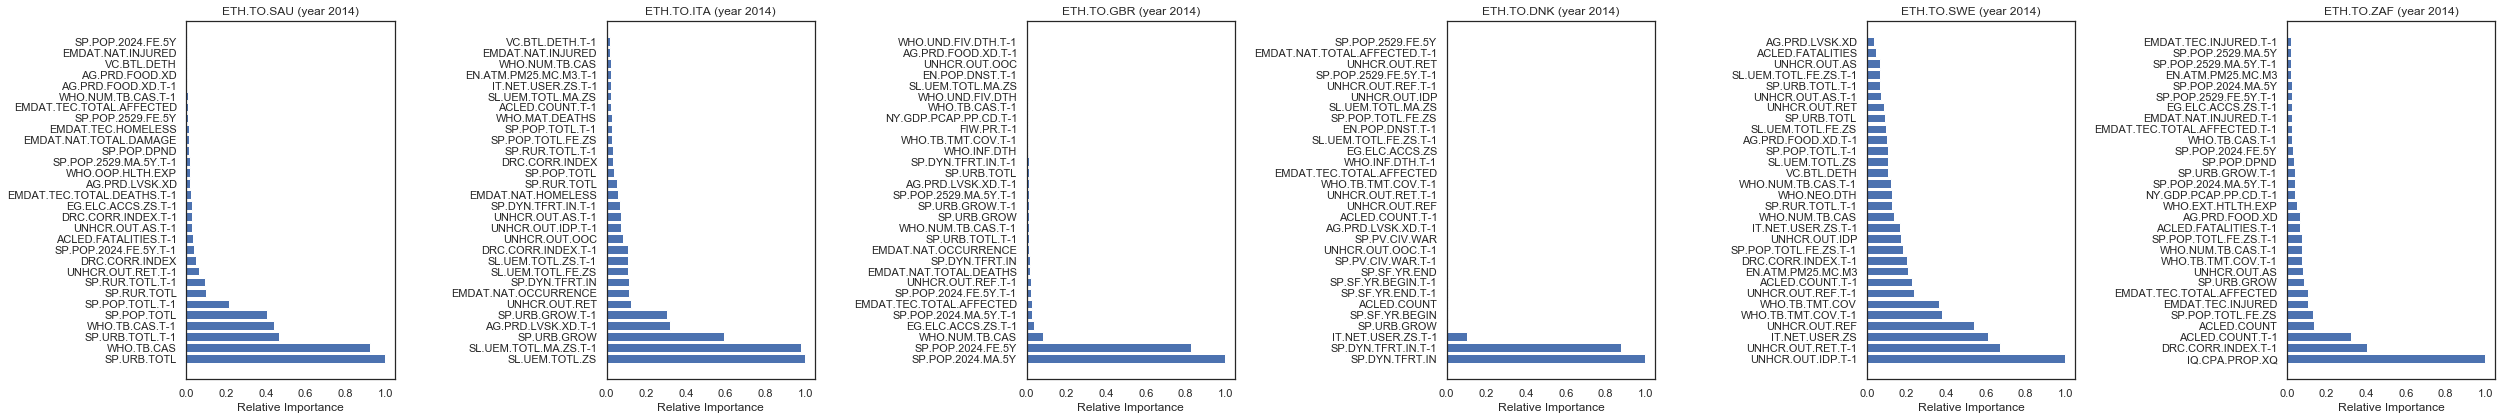

In [71]:
sns.set(style="white")
fig, ax = plt.subplots(1, len(TARGETS), 
                       figsize=(35, 6))

for i, m in enumerate(M):
    
    fi = pd.DataFrame({'fscore': m['model'].steps[1][1].feature_importances_,
                       'features': m['Xt'].columns})
    
    # remove auto-regressive features
    fi = fi[~fi.features.str.startswith(m['target'])]
    
    # Normalize
    delta = fi.fscore.max() - fi.fscore.min()
    fi.fscore = (fi.fscore - fi.fscore.min())/delta
    
    fi = fi.sort_values('fscore', ascending=False).head(30)
    
    pos = np.arange(fi.values.shape[0]) + .5
    ax[i].barh(pos, fi.fscore, align='center')
    ax[i].set_yticks(pos)
    ax[i].set_yticklabels(fi.features.values)
    ax[i].set_xlabel('Relative Importance')
    ax[i].set_title("{} (year {})".format(m['target'], 2014))
fig.tight_layout()

plt.savefig("img/feature-importance.png", dpi=200, bbox_inches='tight')


In [102]:
# Generate an excel sheet with feature importance by target

F = []

for i, m in enumerate(M):
    
    fi = pd.DataFrame({'fscore': m['model'].steps[1][1].feature_importances_,
                       'features': m['Xt'].columns,
                        'target': m['target']})
    
    # remove auto-regressive features
    fi = fi[~fi.features.str.startswith(m['target'])]
    
    # Normalize
    delta = fi.fscore.max() - fi.fscore.min()
    fi.fscore = (fi.fscore - fi.fscore.min())/delta
    
    fi = fi.sort_values('fscore', ascending=False).head(30)
    
    F.append(fi)
    

FDF = pd.concat(F)
    
def rename(x):
    if x.endswith("T-1") | x.endswith("DEST"):
        k = x.split(".")
        return ".".join(k[:-1])
    return x

FDF['target'] = FDF['target'].apply(lambda x: x.split(".")[2])
FDF['features'] = FDF['features'].apply(rename)
FDF = pd.pivot_table(FDF, index='features',
                      columns='target', values='fscore')

FDF[~FDF.isnull()] = 1.0
FDF[FDF.isnull()] = 0.0
FDF.reset_index(inplace=True)

IND = pd.read_excel("Data in MM4Sight.xlsx")
IND = IND.merge(FDF, how='left', left_on='Indicator Code', right_on='features')
IND.to_excel("FeatureImp.xlsx", index=False)

target,features,DNK,GBR,ITA,SAU,SWE,ZAF
0,ACLED.COUNT,1.0,0.0,1.0,0.0,1.0,1.0
1,ACLED.FATALITIES,0.0,0.0,0.0,1.0,1.0,1.0
2,AG.PRD.FOOD.XD,0.0,1.0,0.0,1.0,1.0,1.0
3,AG.PRD.LVSK.XD,1.0,1.0,1.0,1.0,1.0,0.0
4,DRC.CORR.INDEX,0.0,0.0,1.0,1.0,1.0,1.0


# Model explanations

** Work in progress **

In [ ]:
# Instance for which we should look explain
X_TARGET = 'ETH.TO.GBR'
X_YEAR = 2013

model = [k['model'] for k in results if (k['period']['forecast_year'] == X_YEAR) &
                                        (k['target'] == X_TARGET)][0]

_, _, Xv, _ = [k['data']['data'] for k in results if (k['period']['forecast_year'] == X_YEAR) &
                                        (k['target'] == X_TARGET)][0]
    


# compute the SHAP values for every prediction in the validation dataset
shap_values = shap.TreeExplainer(model).shap_values(Xv)
shap.force_plot(shap_values[0, :], Xv.iloc[0,:])

In [ ]:
shap.summary_plot(shap_values, Xv)

# TODO: 

A running list of things to do/try:

- ~~include Sub-Saharan data~~
- ~~temporal lag features~~
- ~~autocorrelation features~~
- label AR(1) and AR(2) features, so that the feature labels are not misleading.
- Feature specific temporal lags (based on cross correlation)
- Address UNDESA annual apportionment of flows, i.e. computation of flows from stock. 
- Additional model forms
- Feature transforms

# Misc.

In [ ]:
# List of Sub-Saharan countries

mystr = """
name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
British Indian Ocean Territory,IO,IOT,086,ISO 3166-2:IO,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Burundi,BI,BDI,108,ISO 3166-2:BI,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Comoros,KM,COM,174,ISO 3166-2:KM,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Djibouti,DJ,DJI,262,ISO 3166-2:DJ,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Eritrea,ER,ERI,232,ISO 3166-2:ER,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Ethiopia,ET,ETH,231,ISO 3166-2:ET,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
French Southern Territories,TF,ATF,260,ISO 3166-2:TF,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Kenya,KE,KEN,404,ISO 3166-2:KE,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Madagascar,MG,MDG,450,ISO 3166-2:MG,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Malawi,MW,MWI,454,ISO 3166-2:MW,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Mauritius,MU,MUS,480,ISO 3166-2:MU,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Mayotte,YT,MYT,175,ISO 3166-2:YT,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Mozambique,MZ,MOZ,508,ISO 3166-2:MZ,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Réunion,RE,REU,638,ISO 3166-2:RE,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Rwanda,RW,RWA,646,ISO 3166-2:RW,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Seychelles,SC,SYC,690,ISO 3166-2:SC,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Somalia,SO,SOM,706,ISO 3166-2:SO,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
South Sudan,SS,SSD,728,ISO 3166-2:SS,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
"Tanzania, United Republic of",TZ,TZA,834,ISO 3166-2:TZ,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Uganda,UG,UGA,800,ISO 3166-2:UG,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Zambia,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014
Zimbabwe,ZW,ZWE,716,ISO 3166-2:ZW,Africa,Sub-Saharan Africa,Eastern Africa,002,202,014"""

from io import StringIO

tmp = pd.read_csv(StringIO(mystr))
tmp.head()